In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import os.path as op
import pickle
import numpy as np
import seaborn as sns
from datetime import date
from scipy import stats
from pandas_profiling import ProfileReport

In [2]:
DATA = op.join(os.getcwd(), "Dataset")

In [3]:
# Importing the data frames from the preprocessed (containing english channels) files
df_channels_en    = pd.read_csv(op.join(DATA,"df_channels_en.tsv.gz"), sep="\t", index_col="channel")
df_num_comments   = pd.read_csv(op.join(DATA,"num_comments.tsv.gz"),sep="\t")
df_timeseries     = pd.read_csv(op.join(DATA,"df_timeseries_en.tsv.gz"),sep="\t")
df_metadata       = pd.read_parquet(op.join(DATA, "df_metadata_feather.parquet.gzip"), engine="fastparquet")

# Looking at the data, and what can we do with it ?

In this section, we look at multiple aspects of the data : what each data frame looks like and each feature's type, missing data, distributions and correlations between some features from each data frame. We also try to see whether some of the features can be transformed or discretized, and whether new ones can be created.

## Looking at the individual data frames and features

### 1. channels_en

In [4]:
df_channels_en.head()

,category_cc,join_date,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights
channel,,,,,,,
UC-lHJZR3Gqxm24_Vd_AJ5Yw,Gaming,2010-04-29,PewDiePie,101000000,3956,3.0,2.087
UCbCmjCuTUZos6Inko4u57UQ,Education,2006-09-01,Cocomelon - Nursery ...,60100000,458,7.0,2.087
UCpEhnqL0y41EpW2TvWAHD7Q,Entertainment,2006-09-20,SET India,56018869,32661,8.0,2.087
UC295-Dw_tDNtZXFeAPAW6Aw,Howto & Style,2016-11-15,5-Minute Crafts,60600000,3591,9.0,2.087
UCJ5v_MCY6GNUBTO8-D3XoAg,Sports,2007-05-11,WWE,48400000,43421,11.0,2.087


In [5]:
df_channels_en.dtypes

category_cc            object
join_date              object
name_cc                object
subscribers_cc          int64
videos_cc               int64
subscriber_rank_sb    float64
weights               float64
dtype: object

This data frame contains information relative to channels, which each have a unique id (stored in the index of the data frame), and are categorized by their, from left to right : 
- category of the channel, can be "Gaming", "Education", "Sports" etc...
- join date in the format yyyy-mm-dd, this format might be a problem when trying to compare different dates, but this will be dealt with later
- name of the channel
- subscriber number
- video number
- subscriber rank : we saw that some channels are missing (for example, the #1 channel) and that this value is of type float, which can be converted to type int as they are whole numbers
- weights, the derivation of which is detailed in the [paper corresponding to the data](https://arxiv.org/abs/2012.10378)

In [6]:
print("The number of rows in the data frame is " + str(len(df_channels_en)) + 
      " and the number of unique ids contained in it is " + str(len(df_channels_en.index.unique())) + ".", "\n"
      "This means that all rows contain data for a specific channel, and that this dataframe contains data of " + 
      str(len(df_channels_en)) + " channels.")

The number of rows in the data frame is 136470 and the number of unique ids contained in it is 136470. 
This means that all rows contain data for a specific channel, and that this dataframe contains data of 136470 channels.


### 2. num_comments

In [7]:
df_num_comments.head()

,display_id,num_comms
0,SBqSc91Hn9g,0.0
1,UuugEl86ESY,0.0
2,oB4c-yvnbjs,48.0
3,ZaV-gTCMV8E,6.0
4,cGvL7AvMfM0,5.0


In [8]:
df_num_comments.dtypes

display_id     object
num_comms     float64
dtype: object

This data frame contains some comment information for each video. From left to right the features are :
- the video id 
- the number of comments, this could be converted to the int type, due to the fact that the number of comments is a whole number

In [9]:
print("The number of rows of the data frame is " + str(len(df_num_comments)) + 
      " and the number of unique ids contained in it is " + str(len(df_num_comments["display_id"].unique())) + ".", "\n"  
      "This means that all rows contain data for a specific comment, and that this dataframe contains data of " + 
      str(len(df_num_comments)) + " comments.")

The number of rows of the data frame is 72924794 and the number of unique ids contained in it is 72924794. 
This means that all rows contain data for a specific comment, and that this dataframe contains data of 72924794 comments.


### 3. timeseries 

In [10]:
df_timeseries.head()

,channel,category,datetime,views,delta_views,subs,delta_subs,videos,delta_videos,activity
0,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-03 00:00:00,2.024946e+05,0.000000,650.222222,0.000000,5,0,3
1,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-10 00:00:00,3.940857e+05,191591.111111,1046.000000,395.777778,6,1,1
2,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-17 00:00:00,8.353938e+05,441308.083333,1501.500000,455.500000,6,0,1
3,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-24 00:00:00,1.104577e+06,269183.250000,1750.000000,248.500000,6,0,0
4,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-31 00:00:00,1.284406e+06,179828.600000,2008.300000,258.300000,6,0,0


In [11]:
df_timeseries.dtypes

channel          object
category         object
datetime         object
views           float64
delta_views     float64
subs            float64
delta_subs      float64
videos            int64
delta_videos      int64
activity          int64
dtype: object

The data frame contains information about channels over time. For each channel, multiple features were recorded at different time points. From left to right, the features are : 
- the channel id
- the category of the channel
- the date and time of the recording
- the total number of views of the channel at the current time point
- the number of gained views during the week preceding the current timepoint
- the number of subscribers at the current time point
- the number of gained subscribers during the week preceding the current timepoint
- the total number of the channel at the current time point
- the difference between the number of videos at the current time point and the number of videos a week before
- the number of published videos during a 15-day period preceding the current timepoint

We can see that some of these values (views, delta_views, subs and delta_subs) are not whole numbers even though they should be. This will be dealt with later.

In [12]:
print("The number of rows of the data frame is " + str(len(df_timeseries)) + 
      " and the number of unique channel ids contained in it is " + str(len(df_timeseries["channel"].unique())) + ".", "\n"
      "This means that this dataframe contains data of " + str(len(df_timeseries["channel"].unique())) + 
      " unique channels for a total of " + str(len(df_timeseries)) + " recordings.")

The number of rows of the data frame is 18872499 and the number of unique channel ids contained in it is 133516. 
This means that this dataframe contains data of 133516 unique channels for a total of 18872499 recordings.


### 4. metadata

In [13]:
df_metadata.head()

,categories,channel_id,dislike_count,display_id,duration,like_count,upload_date,view_count
0,Film & Animation,UCzWrhkg9eK5I8Bm3HfV-unA,1.0,SBqSc91Hn9g,1159,8.0,2016-09-28,1057.0
1,Film & Animation,UCzWrhkg9eK5I8Bm3HfV-unA,1.0,UuugEl86ESY,2681,23.0,2016-09-28,12894.0
2,Film & Animation,UCzWrhkg9eK5I8Bm3HfV-unA,779.0,oB4c-yvnbjs,1394,1607.0,2016-09-28,1800602.0
3,Film & Animation,UCzWrhkg9eK5I8Bm3HfV-unA,24.0,ZaV-gTCMV8E,5064,227.0,2016-09-28,57640.0
4,Film & Animation,UCzWrhkg9eK5I8Bm3HfV-unA,13.0,cGvL7AvMfM0,3554,105.0,2016-09-28,86368.0


In [14]:
df_metadata.dtypes

categories               object
channel_id               object
dislike_count           float64
display_id               object
duration                  int64
like_count              float64
upload_date      datetime64[ns]
view_count              float64
dtype: object

This data frame contains metadata from videos. From left to right, the features are : 
- the category of the video
- the id od the channel that published it
- the video's dislike count
- the video's id
- the video duration
- the video's like count
- the upload date in the format yyyy-mm-dd and of data type datetime64[ns], this format might be a problem when trying to compare different dates, but this will be dealt with later
- the view count

Again, some of the features are represented in the float data type, although they should be whole numbers and this will again be dealt with when necessary later. In this case however, we cannot directly see that some of them actually are now whole numbers.

In [15]:
print("The number of rows of the data frame is " + str(len(df_metadata)) + 
      " and the number of unique channel ids contained in it is " + str(len(df_metadata["channel_id"].unique())) + ".", "\n"
      "This means that this dataframe contains video metadata of " + str(len(df_timeseries["channel"].unique())) + 
      " unique channels for a total of " + str(len(df_metadata)) + " videos.")

The number of rows of the data frame is 72924794 and the number of unique channel ids contained in it is 136470. 
This means that this dataframe contains video metadata of 133516 unique channels for a total of 72924794 videos.


## Handling missing data

In the following subsection we look at missing data for each of the imported data files, and propose a way to deal with them.

### 1. channels_en

In [16]:
for colname in df_channels_en.columns :
    print("Number of rows with missing values of " + colname + " : " + str(len(df_channels_en[df_channels_en[colname].isnull()])))

Number of rows with missing values of category_cc : 128
Number of rows with missing values of join_date : 1
Number of rows with missing values of name_cc : 10
Number of rows with missing values of subscribers_cc : 0
Number of rows with missing values of videos_cc : 0
Number of rows with missing values of subscriber_rank_sb : 0
Number of rows with missing values of weights : 0


Here, three of the columns have missing values : "category", "join_date" and "name_cc". A quick fix for the "category" and "name_cc" columns is to replace missing values with the "Unknown" label :

In [17]:
df_channels_en = df_channels_en.fillna({"category_cc": "Unknown"})
df_channels_en = df_channels_en.fillna({"name_cc": "Unknown"})
df_channels_en[df_channels_en["category_cc"] == "Unknown"].head()

,category_cc,join_date,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights
channel,,,,,,,
UCa_4DcdTB9QfK0LY9-7qWuQ,Unknown,2009-05-12,AbbaVEVO,995000,36,17265.0,2.8200
UCVOftvvuyipcn7102TUFsSQ,Unknown,2012-12-23,Baka Oppai,760128,27,21172.0,2.9225
UCqH2YMSzMaGN92Vc3VkhWnQ,Unknown,2009-06-05,Sony Pictures Home E...,770000,6561,22799.0,2.9595
UCnzCV_PxVZ-hsOrTy2NGxJw,Unknown,2009-10-15,EuropeVEVO,654000,19,27450.0,2.9825
UCSydRCmlHx6na0zWscgAk9w,Unknown,2006-04-25,Warner Movies On Dem...,619000,582,28343.0,3.0095


In [18]:
df_channels_en[df_channels_en["name_cc"] == "Unknown"].head()

,category_cc,join_date,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights
channel,,,,,,,
UCMzbrcOG-edOxonhLbsOD4Q,Entertainment,2014-01-01,Unknown,112543,118,140756.0,5.3190
UC24EknjfMDJhoKpDQKjuT9A,Gaming,2012-06-12,Unknown,103000,598,148300.0,4.4190
UCInBv6ByaxgOXxfddyC7B3g,Entertainment,2015-07-30,Unknown,105000,32,155045.0,5.5035
UCmOiT9ZnSvLZ1XMBFjGiNmQ,Entertainment,2016-07-09,Unknown,55100,26,249430.0,7.0805
UCJIYgIBaQt0YcGO73VCLPyg,Gaming,2015-02-01,Unknown,57000,180,266879.0,6.1480


In [19]:
for colname in ["category_cc", "name_cc"] :
    print("Number of rows with missing values of " + colname + " : " + str(len(df_channels_en[df_channels_en[colname].isnull()])))

Number of rows with missing values of category_cc : 0
Number of rows with missing values of name_cc : 0


We can see from these previous 3 cells that the missing values have been correctly replaced. However, we can't really do anything reasonable for the missing join_date value, so the row containing it will be removed if needed, using the following template :

In [20]:
# template for dropping only rows for some categories :
# the list has to contain the column names that we are interested in 
curr_df = df_channels_en.dropna(subset = ["join_date"])

### 2. num_comments

In [20]:
for colname in df_num_comments.columns :
    print("Number of rows with missing values of " + colname + " : " + str(len(df_num_comments[df_num_comments[colname].isnull()])))

Number of rows with missing values of display_id : 0
Number of rows with missing values of num_comms : 0


No missing data here, so nothing to do here.

### 3. timeseries

In [21]:
for colname in df_timeseries.columns :
    print("Number of rows with missing values of " + colname + " : " + str(len(df_timeseries[df_timeseries[colname].isnull()])))

Number of rows with missing values of channel : 0
Number of rows with missing values of category : 20584
Number of rows with missing values of datetime : 0
Number of rows with missing values of views : 0
Number of rows with missing values of delta_views : 0
Number of rows with missing values of subs : 0
Number of rows with missing values of delta_subs : 0
Number of rows with missing values of videos : 0
Number of rows with missing values of delta_videos : 0
Number of rows with missing values of activity : 0


Here, only one of the columns has missing values, and it is the "category" one. A quick fix to this problem is to replace these missing category values by the label "Unknown" :

In [22]:
df_timeseries = df_timeseries.fillna({"category": "Unknown"})
df_timeseries[df_timeseries["category"] == "Unknown"].head()

,channel,category,datetime,views,delta_views,subs,delta_subs,videos,delta_videos,activity
442874,UChxLXL97wslyFHJiBHgt86w,Unknown,2016-06-20 00:00:00,203924.000,0.000,4178.000,0.00,164,0,4
442875,UChxLXL97wslyFHJiBHgt86w,Unknown,2016-06-27 00:00:00,207172.875,3248.875,4110.625,0.00,165,1,5
442876,UChxLXL97wslyFHJiBHgt86w,Unknown,2016-07-04 00:00:00,210295.000,3122.125,4107.000,0.00,167,2,4
442877,UChxLXL97wslyFHJiBHgt86w,Unknown,2016-07-11 00:00:00,212589.750,2294.750,4110.250,3.25,167,0,2
442878,UChxLXL97wslyFHJiBHgt86w,Unknown,2016-07-18 00:00:00,215376.500,2786.750,4124.500,14.25,170,3,3


In [23]:
for colname in ["category"] :
    print("Number of rows with missing values of " + colname + " : " + str(len(df_timeseries[df_timeseries[colname].isnull()])))

Number of rows with missing values of category : 0


We can see that all rows with missing values for the "category" column have correctly been filled. 

### 4. metadata

In [24]:
for colname in df_metadata.columns :
    print("Number of rows with missing values of " + colname + " : " + str(len(df_metadata[df_metadata[colname].isnull()])))

Number of rows with missing values of categories : 0
Number of rows with missing values of channel_id : 0
Number of rows with missing values of dislike_count : 1631458
Number of rows with missing values of display_id : 0
Number of rows with missing values of duration : 0
Number of rows with missing values of like_count : 1631458
Number of rows with missing values of upload_date : 0
Number of rows with missing values of view_count : 654


In [25]:
print("Number of dropped rows when accounting for all columns: " + str(len(df_metadata) - len(df_metadata.dropna())))

Number of dropped rows when accounting for all columns: 1631458


The above result shows that there are a total of 1.63 million rows missing both the like and dislike counts, 654 of which also is missing the view count. As there is no reasonable way to fill these columns with "fake" values, we will take them out of the data frame if needed, using the same template as was proposed for channels_en :

In [27]:
# template for dropping only rows for some categories :
# the list has to contain the column names that we are interested in 
curr_df = df_metadata.dropna(subset = ["like_count", "dislike_count", "view_count"])

## Distributions, transformation of features and creation of new ones 

In the following subsection we look at the different distributions of some of the features of the data. We also try to transform some of the features (by discretizing them, so that they can for example be used later for methods requiring categorical variables like random forests and decision trees), and enrich the data by creating new ones. 

### 1. Subscriber number of the channels

#### 1.1 Log-log graph and equal width bins

Text(0.5, 1.0, 'Subscribers distribution over channels')

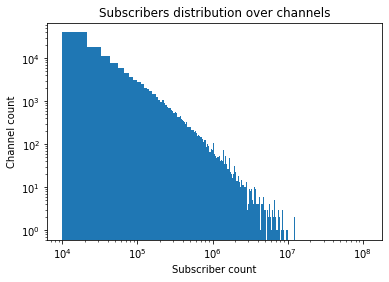

In [38]:
df_channels_en["subscribers_cc"].plot(kind="hist", bins=10000, loglog=True)
plt.xlabel("Subscriber count")
plt.ylabel("Channel count")
plt.title("Subscribers distribution over channels")

#### 1.2 Discretizing the number of subscribers

We can also try to class these channel followings (i.e. discretize the number of subscribers) into "tiny", "very small", "big", "very big" and "mega" channels, where the intervals are :
- [0,500] for "tiny" followings, the subscribers of which could more or less be only people that the creator himself knows
- [500, 10'000] for "very small" followings, the creator cannot know all of his subscribers, but still has a small following 
- [10'000, 50'000] for "small" followings, these channels are starting to have a bigger following, but are still not by any means well known
- [50'000, 1'000'000] for "big" channels that have a big following and could be very well known across small regions, or by people that are scattered all around the world, but not by everyone
- [1'000'000, $\infty$) for "mega" followings, the channels with which could be known in entire countries or by tons of people all around the world
  
This could be interesting in our case as we do not really care about the precise number of subscribers, but rather the order of magnitude of each channel's following.  
These ranges were chosen arbitrarily, but were still carefully chosen to respect some characteristics denoted by their respective descriptions. The "mega" label was inspired by [work](https://koreascience.kr/article/JAKO202124553353172.page) from LE, T. V. et al. who also chose 1 million subscribers as a threshold to define them. The chosen ranges might change in the future depending on their future use and salience. 

In [27]:
df_channels_binned = df_channels_en.copy(deep = True)
df_channels_binned["binned_subs"] = pd.cut(x = df_channels_binned["subscribers_cc"], 
                                           bins = [0, 5e2, 1e4, 5e4, 1e6, 1e11],
                                           right = False, include_lowest = True)
df_channels_binned.head()

,category_cc,join_date,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights,binned_subs
channel,,,,,,,,
UC-lHJZR3Gqxm24_Vd_AJ5Yw,Gaming,2010-04-29,PewDiePie,101000000,3956,3.0,2.087,"[1000000.0, 100000000000.0)"
UCbCmjCuTUZos6Inko4u57UQ,Education,2006-09-01,Cocomelon - Nursery ...,60100000,458,7.0,2.087,"[1000000.0, 100000000000.0)"
UCpEhnqL0y41EpW2TvWAHD7Q,Entertainment,2006-09-20,SET India,56018869,32661,8.0,2.087,"[1000000.0, 100000000000.0)"
UC295-Dw_tDNtZXFeAPAW6Aw,Howto & Style,2016-11-15,5-Minute Crafts,60600000,3591,9.0,2.087,"[1000000.0, 100000000000.0)"
UCJ5v_MCY6GNUBTO8-D3XoAg,Sports,2007-05-11,WWE,48400000,43421,11.0,2.087,"[1000000.0, 100000000000.0)"


In [28]:
df_channels_binned = df_channels_binned.groupby(by = "binned_subs").size()
df_channels_binned = pd.DataFrame(df_channels_binned.values.flatten(), index = ["tiny", "very small", "small", "big", "mega"], columns = ["channel number"])

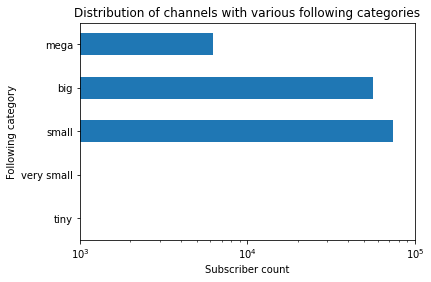

In [40]:
df_channels_binned.plot.barh(log = True, legend = None)
plt.title("Distribution of channels with various following categories")
plt.xlim([1e3, 1e5])
plt.xlabel("Subscriber count")
plt.ylabel("Following category")
plt.show()

#### 1.3 Observations

- We can see from these graphs that all channels in the dataset have over 10'000 subscribers, meaning that our analysis will be restricted to channels with at least 10'000 subscribers.
- Due to the linear shape of the log-log graph above, we can deduce that the subscribers count comes from a heavy-tailed distribution.
- There are less "mega" channels than big and small channels, but the difference is only of about one order of magnitude ! This means that although arbitrary, our choice of bins for the discretization is not so bad.

### 2. Total views per channel, with df_metadata

An interesting feature we would like to consider and use is the total amount of views a channel has accumulated across all of its videos. This could be a good measure of how much the channel "has been seen" in the past.

#### 2.1 Computation of new feature

In [30]:
total_views_metadata = df_channels_en.merge(df_metadata, left_index=True, right_on="channel_id").groupby(by=["channel_id", "name_cc"])["view_count"].sum()

#### 2.2 Log-log graph with equal width bins

Text(0.5, 1.0, 'Total views distribution over channels (metadata)')

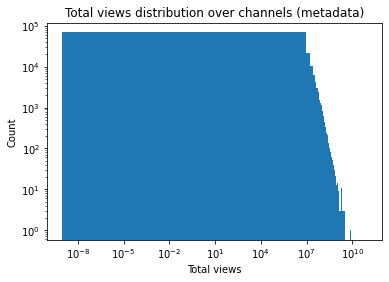

In [31]:
total_views_metadata.plot(kind="hist", bins=10000, loglog=True)
plt.xlabel("Total views")
plt.ylabel("Count")
plt.title("Total views distribution over channels (metadata)")

#### 2.3 Discretization of  the total number of views

Again, it could be interesting to discretize this variable, as the precise number of total views might not be very important and the magnitude would suffice. The proposed classification for the number of total views per channel is : 
- [0,5000] for a "tiny" viewership, where the creator might know all people that have viewed his videos
- [5000, 100'000] for a "very small" viewership, the creator cannot know all of the people that have seen his videos, but still has a relatively small viewership
- [100'000, 500'000] for a "small" viewership, these channels are starting to get a relatively big viewership, but are still not by any means well known
- [500'000, 10'000'000] for a "big" viewership, the channels could have a big following and could be very well known across small regions, or by people that are scattered all around the world, but not by everyone
- [10'000'000, $\infty$) for "mega" viewerships, the channels with which could be known in entire countries or by tons of people all around the world

These ranges were chosen arbitrarily, but were still carefully chosen to respect some characteristics denoted by their respective descriptions. The idea behind the  bounds is that they correspond to the situation where channels with the corresponding labels defined in 1.2 had published 10 videos which were each seen once by each of their subscribers. The chosen ranges might change in the future depending on their future use and salience. 

In [44]:
total_views_binned = pd.DataFrame(total_views_metadata)
total_views_binned["binned_views"] = pd.cut(x = total_views_binned["view_count"], bins = [0, 5e3, 1e5, 5e5, 1e7, 1e15], right = False, include_lowest = True)
total_views_binned.head()

,,view_count,binned_views
channel_id,name_cc,,
UC--24Q3_ZQeFmgJE-Um5QZQ,Winded Voyage Sailin...,3291383.0,"[500000.0, 10000000.0)"
UC--2EbuIuBOGgGqPiJxi3rg,The Night Fury,7999515.0,"[500000.0, 10000000.0)"
UC--3c8RqSfAqYBdDjIG3UNA,Red Bull Surfing,63626751.0,"[10000000.0, 1000000000000000.0)"
UC--3ozenTzry39-xMqAPQlw,Heidi Joubert,5192527.0,"[500000.0, 10000000.0)"
UC--6E6EpybocdaNlPhvK_9A,MR JC,9317278.0,"[500000.0, 10000000.0)"


In [45]:
total_views_binned = total_views_binned.groupby(by = "binned_views").size()
total_views_binned = pd.DataFrame(total_views_binned.values.flatten(), index = ["tiny", "very small", "small", "big", "mega"], columns = ["channel id"])

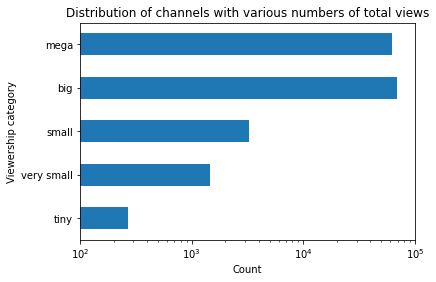

In [46]:
total_views_binned.plot.barh(log = True, legend = None)
plt.title("Distribution of channels with various numbers of total views")
plt.xlim([1e2, 1e5])
plt.xlabel("Count")
plt.ylabel("Viewership category")
plt.show()

#### 2.4 Observations
- Due to the linear shape of the log-log graph above, we can deduce that the total views count comes from a heavy-tailed distribution.
- We can see from these graphs that there are still channels with "tiny" and "very small" viewerships, even though there are no tiny and very small channels. This could be explained by the fact that some channels might have large followings without it being due to their videos; maybe the creators were already well known on other platforms, and simply created their channel without positing many videos. 
- Even though the aforementionned viewership categories can be observed, they are still not very prominent. The three biggest categories are the last three, i.e. "small", "big" and "mega", the difference between the three being of about 2 orders of magnitude which is acceptable.

### 3. Total views per channel with df_timeseries

We actually noticed that we could compute the total number of views in 2 separate ways, the second one being by using the timeseries data, which we do here.

#### 3.1 Computation of new feature

In [47]:
total_views = df_channels_en.merge(df_timeseries, left_index=True, right_on="channel").groupby(by=["channel", "name_cc"])["views"].max()

#### 3.2 Log-log graph with equal width bins

Text(0.5, 1.0, 'Total views distribution over channels (timeseries)')

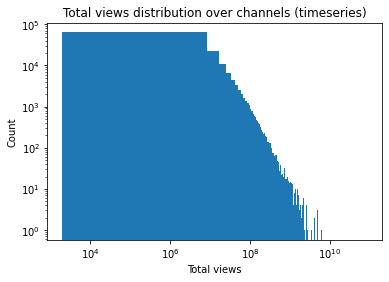

In [50]:
total_views.plot(kind="hist", bins=10000, loglog=True)
plt.xlabel("Total views")
plt.ylabel("Count")
plt.title("Total views distribution over channels (timeseries)")

#### 3.3 Realize that total views differ in the two datasets

As demonstrated by the following cells of code, we noticed that the computed total views differ depending on which data is used.

In [51]:
# concatenate both dataframes
both = pd.concat([total_views, total_views_metadata])

In [53]:
# keep only the channels for which we have data in both the dataframes
both[both.index.duplicated(keep=False)]

channel                   name_cc                
UC--24Q3_ZQeFmgJE-Um5QZQ  Winded Voyage Sailin...    4.356804e+06
UC--2EbuIuBOGgGqPiJxi3rg  The Night Fury             7.951972e+06
UC--3c8RqSfAqYBdDjIG3UNA  Red Bull Surfing           5.798712e+07
UC--3ozenTzry39-xMqAPQlw  Heidi Joubert              1.455123e+07
UC--6E6EpybocdaNlPhvK_9A  MR JC                      9.166274e+06
                                                         ...     
UCzztaOtjmaZoiLvWLagq7bg  Def Noodles                2.554022e+07
UCzzyt9Z70MBX9RQAFVSNlpQ  CherryGumz Gacha           4.939140e+06
UCzzzPMh9fZHxc7gxPRB2LHQ  Elisa Jane Tarot Car...    1.279275e+07
UCzzzUN8yvD2LRAnY-lhzyLQ  DropNight                  8.335020e+07
UCzzzZ3-icktxbC3j7hkWqRw  Citalia                    1.131340e+07
Length: 267032, dtype: float64

In [54]:
# look at the values for a specific channel in both dataframes
both[both.index.duplicated(keep=False)]["UCrUsv6k8WEcHVsiN8t1T33A"]

name_cc
AH2128    8.671292e+06
AH2128    9.049810e+06
dtype: float64

We can see that depending on what data is used, the total number of views differs ! This is due to two things :
- df_metadata contains videos created between 2005 and 2019, whereas df_timeseries contains videos created between January 2015 and September 2019
- Not all channels in df_timeseries have the complete time frame.

Therefore, we still have to decide which of the values (or maybe, both) will be used in further analysis.

### 4. Average durations of videos

Another metric we can try to compute is the average duration of the videos.

In [61]:
avg_durations = df_metadata.groupby(by=["channel_id"])["duration"].mean()

Text(0.5, 1.0, 'Average video duration distribution over channels')

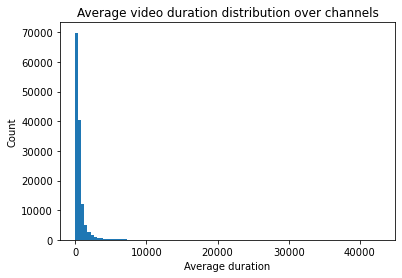

In [67]:
avg_durations.plot(kind="hist", bins=100)
plt.xlabel("Average duration")
plt.ylabel("Count")
plt.title("Average video duration distribution over channels")

Text(0.5, 1.0, 'Average video duration distribution over channels')

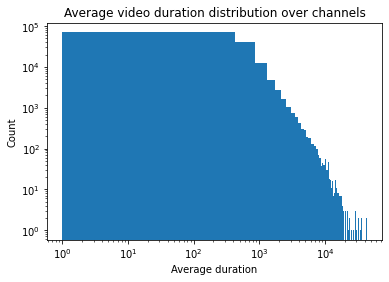

In [68]:
avg_durations.plot(kind="hist", bins=100, loglog=True)
plt.xlabel("Average duration")
plt.ylabel("Count")
plt.title("Average video duration distribution over channels")

The data again seems heavy-tailed ! We could again try to discretize this variable as was done before, although this doesn't seem quite as interesting (how do we define short, medium, long videos?), or we could also try to log transform the values for further use. 

### 5. Average activity of channels

We also try to see whether the average activity of channels could be interesting.

In [64]:
avg_activity = df_timeseries.groupby(by=["channel"])["activity"].mean()

Text(0.5, 1.0, 'Average activity distribution over channels')

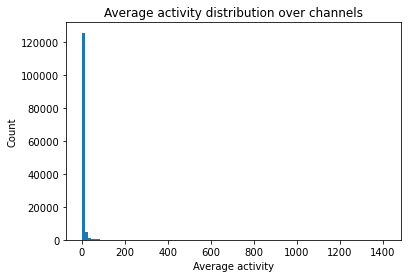

In [69]:
avg_activity.plot(kind="hist", bins=100)
plt.xlabel("Average activity")
plt.ylabel("Count")
plt.title("Average activity distribution over channels")

Text(0.5, 1.0, 'Average activity distribution over channels')

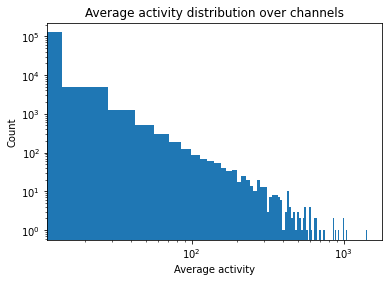

In [70]:
avg_activity.plot(kind="hist", bins=100, loglog=True)
plt.xlabel("Average activity")
plt.ylabel("Count")
plt.title("Average activity distribution over channels")

Again the data looks heavy-tailed ! We could again try to discretize this variable as was done before, although again this doesn't seem quite as interesting (how do we define small, medium, big activity?), or we could also try to log transform the values for further use. 

### 6. Video type distributions 

Looking at the video type distributions can be interesting for seeing what type of content might have the biggest like count. In general :

In [78]:
df_metadata.groupby("categories").size().rename(index = {'':'Unknown'})

categories
Unknown                      1522
Autos & Vehicles          2256967
Comedy                    1172503
Education                 3795564
Entertainment            12276397
Film & Animation          2359736
Gaming                   13720303
Howto & Style             3968127
Movies                          5
Music                     8305003
News & Politics           8881022
Nonprofits & Activism      777449
People & Blogs            6910666
Pets & Animals             645508
Science & Technology      2403004
Shows                          41
Sports                    4354412
Travel & Events           1096565
dtype: int64

Now, for the top channels, the distribution drastically changes :

In [77]:
df_metadata.sort_values(by = "like_count", ascending = False)[0:1000].groupby(['categories']).size()

categories
Autos & Vehicles           1
Comedy                    15
Education                 13
Entertainment             68
Film & Animation           7
Gaming                     8
Howto & Style              3
Music                    864
News & Politics            2
Nonprofits & Activism      1
People & Blogs            10
Science & Technology       1
Sports                     7
dtype: int64

We can for example see that from the 1000 most liked videos, 864 are of "Music" category. 

### 7. Small notes on further feature transformations

Some additional feature transformations were needed as we wanted to consider some additional features when looking at correlations in the next section. Mainly, this involved transforming non-numeric features into numeric ones so we could use the ".corr" method for data frames. As these feature transformations were only used in the following subsection, they were left there for now (and are highlighted in bold for better identification!)

## Correlations

In the following subsection we look at the correlation between some of the variables of some of the dataframes that were provided. This was done only for df_channels_en.

In [50]:
# Here we want to drop all rows with missing values so they aren't used
curr_df = df_channels_en.dropna()
curr_df.corr(method = "pearson")

,subscribers_cc,videos_cc,subscriber_rank_sb,weights
subscribers_cc,1.000000,0.086100,-0.241136,-0.172285
videos_cc,0.086100,1.000000,-0.062582,-0.043246
subscriber_rank_sb,-0.241136,-0.062582,1.000000,0.738400
weights,-0.172285,-0.043246,0.738400,1.000000


We can see that the correlations only happen between numerical values. A metric that could be interesting even though not numerical in the data frame is the join date. Joining YouTube earlier could have an impact. Therefore, the following function can be coded so that we can transform the join date in a numerical variable (i.e. the number of days between the reference date and the join date) (**first feature transformation**) :

In [51]:
def transform_date(date_tbt, ref_date) :
    """
    Args :
        date_tbt :  (str), contains the date we want to transform with format "year-month-day"
        ref_date :  (str), contains reference date with format "year-month-day"
        
    Returns :
        res_str :   (int), number of days between reference data and given date
    """
    if(isinstance(date_tbt, float)) :
        print(date_tbt)
    ref_date_list = ref_date.split(sep = "-")
    date_tbt_list = date_tbt.split(sep = "-")
    return (date(int(date_tbt_list[0]), int(date_tbt_list[1]), int(date_tbt_list[2])) - date(int(ref_date_list[0]), int(ref_date_list[1]), int(ref_date_list[2]))).days

As the first data that we have is from the 2005, we will use the 1st of January 2005 as the reference date. We then get :

In [52]:
ref_date = "2005-1-1"
curr_df["existance_days"] = [transform_date(date_tbt, ref_date) for date_tbt in curr_df["join_date"].values]
curr_df.drop("join_date", inplace = True, axis = 1)
curr_df

C:\Users\sande\AppData\Local\Temp/ipykernel_5512/985236246.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curr_df["existance_days"] = [transform_date(date_tbt, ref_date) for date_tbt in curr_df["join_date"].values]
C:\Users\sande\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,category_cc,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights,existance_days
channel,,,,,,,
UC-lHJZR3Gqxm24_Vd_AJ5Yw,Gaming,PewDiePie,101000000,3956,3.0,2.0870,1579
UCbCmjCuTUZos6Inko4u57UQ,Education,Cocomelon - Nursery ...,60100000,458,7.0,2.0870,243
UCpEhnqL0y41EpW2TvWAHD7Q,Entertainment,SET India,56018869,32661,8.0,2.0870,262
UC295-Dw_tDNtZXFeAPAW6Aw,Howto & Style,5-Minute Crafts,60600000,3591,9.0,2.0870,3971
UCJ5v_MCY6GNUBTO8-D3XoAg,Sports,WWE,48400000,43421,11.0,2.0870,495
...,...,...,...,...,...,...,...
UCuM-9AajUOwKw6ipOzu2DRQ,Music,GONE.Fludd - Topic,10128,105,1008139.0,53.1435,3931
UCtW9jp5TH0YrgYpwiRf9t-Q,People & Blogs,saidthestory,10100,352,1008644.0,53.1435,2846
UCTsxFTIUs8vFDzGccDm6i7Q,Gaming,Omni H,10000,475,1009505.0,53.1435,3414


Another interesting feature that could be interesting to include is the channel category. Let's use dummy variables for this (**second feature transformation**) :

In [53]:
dummies_df = pd.get_dummies(curr_df["category_cc"])
full_df = curr_df.merge(dummies_df, left_index=True, right_on="channel")
full_df.drop("category_cc", inplace = True, axis = 1)

We can't do much with the channel names, so let's remove them for now. 

In [54]:
full_df.drop("name_cc", inplace = True, axis = 1)

We now look at the linear correlation between the different features, keeping only the strong (>0.7, [source](https://journals.lww.com/anesthesia-analgesia/fulltext/2018/05000/correlation_coefficients__appropriate_use_and.50.aspx)) and significant ones.

In [55]:
for i in range(len(full_df.columns)) :
    for j in range(i, len(full_df.columns)) :
        if(abs(i-j) > 0 and not(i > 5 and j > 5)) :
            r, pval = stats.pearsonr(full_df[full_df.columns[i]].values, full_df[full_df.columns[j]].values)
            if(pval < 0.05 and abs(r) > 0.7) :
                print("Pearson correlation is significant between " + full_df.columns[i] + " and " + full_df.columns[j] + 
                      ". The p-value is " + str(pval) + " and the correlation coefficient is " + str(r))
                print()

Pearson correlation is significant between subscriber_rank_sb and weights. The p-value is 0.0 and the correlation coefficient is 0.7383999363445934



In [56]:
for i in range(len(full_df.columns)) :
    for j in range(i, len(full_df.columns)) :
        if(abs(i-j) > 0 and not(i > 5 and j > 5)) :
            r, pval = stats.spearmanr(full_df[full_df.columns[i]].values, full_df[full_df.columns[j]].values)
            if(pval < 0.05 and abs(r) > 0.7) :
                print("Spearman correlation is significant between " + full_df.columns[i] + " and " + full_df.columns[j] + 
                      ". The p-value is " + str(pval) + " and the correlation coefficient is " + str(r))
                print()

Pearson correlation is significant between subscribers_cc and subscriber_rank_sb. The p-value is 0.0 and the correlation coefficient is -0.9937197228151681

Pearson correlation is significant between subscribers_cc and weights. The p-value is 0.0 and the correlation coefficient is -0.9609484981665265

Pearson correlation is significant between subscriber_rank_sb and weights. The p-value is 0.0 and the correlation coefficient is 0.9650708046186821



We can see that the "subscribers_cc", "subscriber_rank_sb" and "weights" features are strongly (coefficients > 0.95) and significantly (p-values < 0.05) correlated. This makes as they are all three related to the number of subscribers a particular channel has. 

# Studying "buzz"

In the following section, we start our actual analysis and interpretation of the data, and try to start getting to the heart of our project. However, this is still a work in progress.

## Finding "buzz" channels

In [63]:
timeseries_buzz = df_timeseries_raw.groupby("channel").max("views")
timeseries_buzz["buzz"] = timeseries_buzz["views"]/timeseries_buzz["subs"]
channels_buzz_sorted = timeseries_buzz.sort_values("buzz", ascending=False)
channels_buzz_sorted

,views,delta_views,subs,delta_subs,videos,delta_videos,activity,buzz
channel,,,,,,,,
UCthGJarCVyno_iRNGCWwTJg,7.987945e+07,2.329690e+06,24.000000,0.000000,0,0,0,3.328310e+06
UC4xXB0x5qXQAagFDnsAl8tg,4.377455e+07,2.550937e+06,16.760417,1.178346,0,0,0,2.611782e+06
UCme84UhHwLSVg-eH0O-yl_g,1.965372e+07,1.174699e+06,16.000000,0.875000,0,0,0,1.228358e+06
UCuQbG58vgoHRcEHMRhWPzTQ,3.020381e+06,8.149162e+04,10.000000,0.600000,0,0,0,3.020381e+05
UCn0D62zdV2qEv9ziv-_DGxA,7.978240e+06,9.697992e+05,114.754300,9.013889,12,3,4,6.952454e+04
...,...,...,...,...,...,...,...,...
UCfNWf9YsYrnZZtiTSqL9f6w,1.981018e+03,2.109468e+02,13582.222222,2847.444444,119,17,26,1.458537e-01
UCBN5uTeKYOdrrHEqRhhtkww,2.915800e+03,3.694444e+01,20458.300000,0.000000,14,2,4,1.425241e-01
UCeoJb2SjcLWHGZWfiD9sM-w,2.677521e+04,3.023125e+03,210005.952381,1472.875000,15,12,12,1.274974e-01


## Finding buzz videos

In [64]:
buzz = df_timeseries_raw[df_timeseries_raw["delta_views"]/df_timeseries_raw["subs"] > 1000000]
buzz

,channel,category,datetime,views,delta_views,subs,delta_subs,videos,delta_videos,activity
658890,UCz0yhTJVJoN20-e5FKJhkeg,Film and Animation,2017-06-19 01:00:00,1.053009e+08,1.711349e+07,17.000,0.0,0,0,0
7362811,UCjTtxUhrLl5Arwv1k36MS-g,People & Blogs,2018-01-15 00:00:00,4.476940e+07,4.476218e+07,38.125,0.0,1,0,1
18607300,UC96TwRI_I8Xi8g96CzIgR6Q,Entertainment,2017-10-23 00:00:00,5.684212e+07,1.432957e+07,11.000,0.0,0,0,0


In [65]:
df_channels_raw.loc[buzz["channel"]]["name_cc"]

channel
UCz0yhTJVJoN20-e5FKJhkeg    KIDS ZONE TV RHYMES
UCjTtxUhrLl5Arwv1k36MS-g       Guka Family Show
UC96TwRI_I8Xi8g96CzIgR6Q               FiveKidz
Name: name_cc, dtype: object

In [66]:
merged = df_channels_raw.merge(df_metadata, left_index=True, right_on="channel_id")
merged["buzz"] = merged["view_count"]/merged["subscribers_cc"]
buzz_sorted = merged.sort_values("buzz", ascending=False)

In [67]:
print("Duration means:")
print("    Total   : " + str(buzz_sorted["duration"].mean()/60))
print("    Buzz    : " + str(buzz_sorted[:1000]["duration"].mean()/60))
print("    Not buzz: " + str(buzz_sorted[-1000:]["duration"].mean()/60))

Duration means:
    Total   : 12.627935625936313
    Buzz    : 6.04105
    Not buzz: 14.084166666666667


In [68]:
print("Duration medians:")
print("    Total   : " + str(buzz_sorted["duration"].median()/60))
print("    Buzz    : " + str(buzz_sorted[:1000]["duration"].median()/60))
print("    Not buzz: " + str(buzz_sorted[-1000:]["duration"].median()/60))

Duration medians:
    Total   : 4.733333333333333
    Buzz    : 3.566666666666667
    Not buzz: 4.983333333333333


In [69]:
with_likes = buzz_sorted[(buzz_sorted["like_count"] > 0) & (buzz_sorted["view_count"] > 0)]
print("Likes/views ratio means:")
print("    Total   : " + str((with_likes["like_count"] / with_likes["view_count"]).mean() * 100))
print("    Buzz    : " + str((with_likes[:1000]["like_count"] / with_likes[:1000]["view_count"]).mean() * 100))
print("    Not buzz: " + str((with_likes[-1000:]["like_count"] / with_likes[-1000:]["view_count"]).mean() * 100))

Likes/views ratio means:
    Total   : 2.411879246744238
    Buzz    : 0.5001628628791016
    Not buzz: 14.568785304451662


In [70]:
print("Likes/views ratio medians:")
print("    Total   : " + str((with_likes["like_count"] / with_likes["view_count"]).median() * 100))
print("    Buzz    : " + str((with_likes[:1000]["like_count"] / with_likes[:1000]["view_count"]).median() * 100))
print("    Not buzz: " + str((with_likes[-1000:]["like_count"] / with_likes[-1000:]["view_count"]).median() * 100))

Likes/views ratio medians:
    Total   : 1.5544041450777202
    Buzz    : 0.4258255931238914
    Not buzz: 4.761904761904762


# Compare video counts vs actual number of videos in dataset

In this final section, we look at some other unusual observations and incoherences between the df_channels_en data frame and df_timeseries data frame, and try to see how many channels actually have matching data in both. 

In [71]:
df_channels_en.sort_values("videos_cc", ascending=False)

,category_cc,join_date,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights
channel,,,,,,,
UCHTK-2W11Vh1V4uwofOfR4w,News & Politics,2015-06-17,AP Archive,1770000,461923,6059.0,2.4625
UCNE227nPPd04KCtOK7_T7UQ,Howto & Style,2012-11-05,Emma Saying,512000,332703,34549.0,3.1865
UCqYw-CTd1dU2yGI71sEyqNw,News & Politics,2007-10-29,GMA News,4436635,308522,1596.0,2.0870
UCoLrcjPV5PbUrUyXq5mjc_A,Sports,2005-12-25,MLB,2130000,278430,5812.0,2.4645
UCEaTAQbuyJ_FWOOQ5OsbK5A,Howto & Style,2008-12-11,Shop Zappos,65000,258643,221575.0,5.9680
...,...,...,...,...,...,...,...
UCyxLCaVDZJlphhMS1iudS8g,People & Blogs,2018-11-20,ItzGacha Krista,15200,10,669409.0,9.2315
UC8_QEmzaN97pPbCIMGLZtag,Music,2015-12-28,Squadra Officiel,167419,10,96544.0,3.5610
UCKWs5SmYtZ1ERpw_o3QyeCg,Film and Animation,2015-09-18,Last Enemy,15200,10,669440.0,9.2460


In [72]:
for index, channel in df_channels_en.sort_values("videos_cc", ascending=False).iterrows():
    videos = df_metadata[df_metadata["channel_id"] == channel.name]
    if len(videos) > 0:
        print(f"{channel['name_cc']}: {len(videos)} videos in df_metadata, {channel['videos_cc']} indicated in df_channels_en.")
        break

AP Archive: 33204 videos in df_metadata, 461923 indicated in df_channels_en.


We have to check for which channels id the number of video we compute using the channels,timeseries and metadata dataset are rougly the same: 

In [8]:
video_count=df_metadata.groupby('channel_id').count()
video_count=video_count['categories'].rename('count_metadata')

In [9]:
video_count2=df_timeseries.sort_values(by='datetime').groupby('channel').last()['videos']
video_count2=video_count2.rename('count_timeseries')

In [10]:
#Checking channels id present in metadata but not in timeseries 
print('There are ',len(set(list(video_count.index))-set(list(video_count2.index))),'channel in the metadata datasets but not in the timeseries dataset')
print('There are ',len(set(list(video_count2.index))-set(list(video_count.index))),'channel in the timeseries datasets but not in the metadata dataset')
print('There are ',len(set(list(video_count.index))-set(list(df_channels_en.index))),'channel in the metadata datasets but not in the channel dataset')
print('There are ',len(set(list(df_channels_en.index))-set(list(video_count.index))),'channel in the channel datasets but not in the metadata dataset')

There are  2954 channel in the metadata datasets but not in the timeseries dataset
There are  0 channel in the timeseries datasets but not in the metadata dataset
There are  0 channel in the metadata datasets but not in the channel dataset
There are  0 channel in the channel datasets but not in the metadata dataset


We thus decide to only keep channel id present in both metadata and time serires dataset:

In [11]:
video_count_filtered=video_count.filter(items = list(video_count2.index), axis=0)

In [12]:
#Checking that our indexes match
print('There are ',(video_count_filtered.index!=video_count2.index).sum(),' different(s) index(es)')

There are  0  different(s) index(es)


In [13]:
count_concat=pd.concat([video_count_filtered,video_count2],axis=1)
count_concat.head()

,count_metadata,count_timeseries
UC--24Q3_ZQeFmgJE-Um5QZQ,189,188
UC--2EbuIuBOGgGqPiJxi3rg,60,60
UC--3c8RqSfAqYBdDjIG3UNA,333,333
UC--3ozenTzry39-xMqAPQlw,43,43
UC--6E6EpybocdaNlPhvK_9A,31,31


To use the time series dataset with the metadata one and keep a reasonable amount of data, we decide to keep only the channel ids for which the number of video according to the metadata dataset has an an absolute difference with the number of video according to the timeseries dataset of 3 at most. 

In [14]:
diff_video_count=count_concat['count_metadata']-count_concat['count_timeseries']
diff_video_count_abs=diff_video_count.apply(lambda x: np.abs(x))
diff_video_count_abs[diff_video_count_abs<=3]

UC--24Q3_ZQeFmgJE-Um5QZQ    1
UC--2EbuIuBOGgGqPiJxi3rg    0
UC--3c8RqSfAqYBdDjIG3UNA    0
UC--3ozenTzry39-xMqAPQlw    0
UC--6E6EpybocdaNlPhvK_9A    0
                           ..
UCzzsKg4jPGBL05t2w3HfHBA    0
UCzzt-UNlRHbEFY3rEpFpuXw    0
UCzztaOtjmaZoiLvWLagq7bg    1
UCzzyt9Z70MBX9RQAFVSNlpQ    0
UCzzzZ3-icktxbC3j7hkWqRw    0
Length: 120168, dtype: int32

In [15]:
new_channel_ids=list(diff_video_count_abs[diff_video_count_abs<=3].index)

In [16]:
df_metadata_clean=df_metadata[df_metadata['channel_id'].isin(new_channel_ids)]

In [17]:
df_channels_en_clean=df_channels_en.filter(items = new_channel_ids,axis=0)

In [130]:
with open(DATA + "df_metadata_clean.pickle", "wb") as f:
    pickle.dump(df_metadata_clean, f)
with open(DATA + "df_channels_en_clean.pickle", "wb") as f:
    pickle.dump(df_channels_en_clean, f)

In [21]:
count_concat=count_concat.filter(items=new_channel_ids,axis=0)

In [22]:
count_concat2=pd.concat([df_channels_en_clean['videos_cc'].rename('count_channel'),count_concat],axis=1)
count_concat2

,count_channel,count_metadata,count_timeseries
UC--24Q3_ZQeFmgJE-Um5QZQ,192,189,188
UC--2EbuIuBOGgGqPiJxi3rg,62,60,60
UC--3c8RqSfAqYBdDjIG3UNA,337,333,333
UC--3ozenTzry39-xMqAPQlw,81,43,43
UC--6E6EpybocdaNlPhvK_9A,31,31,31
...,...,...,...
UCzzsKg4jPGBL05t2w3HfHBA,14,14,14
UCzzt-UNlRHbEFY3rEpFpuXw,288,282,282
UCzztaOtjmaZoiLvWLagq7bg,372,298,297
UCzzyt9Z70MBX9RQAFVSNlpQ,22,22,22


In [26]:
#Computing absolute difference between count form channel and count from timeseries and metadata
count_concat2['channel_minus_metadata']=(count_concat2['count_channel']-count_concat2['count_metadata']).apply(lambda x:np.abs(x))
count_concat2['channel_minus_timeseries']=(count_concat2['count_channel']-count_concat2['count_timeseries']).apply(lambda x:np.abs(x))

In [30]:
#If we allow for a difference of at most three, we get 91402 channel ids
count_concat2[(count_concat2['channel_minus_metadata']<=3) |(count_concat2['channel_minus_timeseries']<=3)]

,count_channel,count_metadata,count_timeseries,channel_minus_metadata,channel_minus_timeseries
UC--24Q3_ZQeFmgJE-Um5QZQ,192,189,188,3,4
UC--2EbuIuBOGgGqPiJxi3rg,62,60,60,2,2
UC--6E6EpybocdaNlPhvK_9A,31,31,31,0,0
UC--70ql_IxJmhmqXqrkJrWQ,247,245,243,2,4
UC--94OGFAzYDOJb0eXgMjew,42,43,42,1,0
...,...,...,...,...,...
UCzzgEOi0xR9SuflkXmTQv6g,121,118,118,3,3
UCzzqd0yx7h1PuC3KJVqeJgw,271,272,271,1,0
UCzzsKg4jPGBL05t2w3HfHBA,14,14,14,0,0
UCzzyt9Z70MBX9RQAFVSNlpQ,22,22,22,0,0


In [31]:
count_concat2[(count_concat2['count_channel']==count_concat2['count_metadata']) & (count_concat2['count_metadata']==count_concat2['count_timeseries'])]

,count_channel,count_metadata,count_timeseries,channel_minus_metadata,channel_minus_timeseries
UC--6E6EpybocdaNlPhvK_9A,31,31,31,0,0
UC--EwQJeJ6SKlJdswehQH4g,51,51,51,0,0
UC--bRDxn5YWEiqs3p8zzvlw,142,142,142,0,0
UC--g_wJaqDjFx57RPrtSpow,15,15,15,0,0
UC--lqu1v7hxajuC1TlmtT0Q,39,39,39,0,0
...,...,...,...,...,...
UCzzUx3uOjiRM-FsBH027O9w,49,49,49,0,0
UCzzbaQY1nPim5yroAjtXRTw,81,81,81,0,0
UCzzsKg4jPGBL05t2w3HfHBA,14,14,14,0,0
UCzzyt9Z70MBX9RQAFVSNlpQ,22,22,22,0,0


There are only 34609 channels id for which the video counts match! In further analysis, we might consider using only these, or also the others, depending on the application !